# Análise e Exploração do dados de Imoveis das casas de King County

Este conjunto de dados contém preços de venda de casas para King County, que inclui Seattle. Inclui casas vendidas entre maio de 2014 e maio de 2015. O intuito é encontrar a tendencia dos preços e poder prever seu valor.

Usarei uma base conhecida do Kaggle: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data


### Descrição das colunas

Temos 21 colunas no conjunto de dados, como segue:

1. id: ID exclusivo para cada casa vendida
1. date: Data da venda da casa
1. price: Preço de cada casa vendida
1. bedrooms: Número de quartos
1. bathrooms: Número de banheiros, onde 0,5 representa um cômodo com vaso 1. sanitário, mas sem chuveiro
1. sqft living: Metragem quadrada do espaço interno do apartamento
1. sqft lot: Metragem quadrada do terreno
1. floors: Número de andares
1. waterfront: Uma variável fictícia para saber se o apartamento tinha vista para 1. a orla ou não
1. view: Um índice de 0 a 4 de quão boa era a vista da propriedade
1. condition: Um índice de 1 a 5 sobre a condição do apartamento
1. grade: Um índice de 1 a 13, onde 1 fica aquém da construção e design do 1. edifício e 13 tem um alto nível de qualidade de construção e design
1. sqft above: A metragem quadrada do espaço interno da habitação que está acima 1. do nível do solo
1. sqft basement: A metragem quadrada do espaço interno da habitação que está 1. abaixo do nível do solo
1. yr built: O ano em que a casa foi construída inicialmente
1. ano reformado: O ano da última reforma da casa
1. Zip Code: Em qual área do CEP a casa está
1. lat: Lattitude
1. long: Longitude
1. sqft living15: A metragem quadrada do espaço de moradia interna para os 15 1. vizinhos mais próximos
1. sqft lot15: A metragem quadrada dos lotes de terra dos 15 vizinhos mais próximos

## Importando bibliotecas necessarias para o estudo

In [1]:
!pip install kaggle


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Impotando os dados do Kaggle

In [3]:
# Baixando o Zip do Kaggle
!kaggle datasets download -d harlfoxem/housesalesprediction


Dataset URL: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction
License(s): CC0-1.0
  0% 0.00/780k [00:00<?, ?B/s]
100% 780k/780k [00:00<00:00, 31.2MB/s]


In [4]:
!unzip /content/housesalesprediction.zip


Archive:  /content/housesalesprediction.zip
  inflating: kc_house_data.csv       


In [5]:
df_house_sales = pd.read_csv('/content/kc_house_data.csv', sep=',')

df_house_sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Iniciando a exploração dos dados

In [6]:
df_house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
df_house_sales.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [8]:
df_house_sales['date'] = pd.to_datetime(df_house_sales['date'].str[:8], format='%Y%m%d')


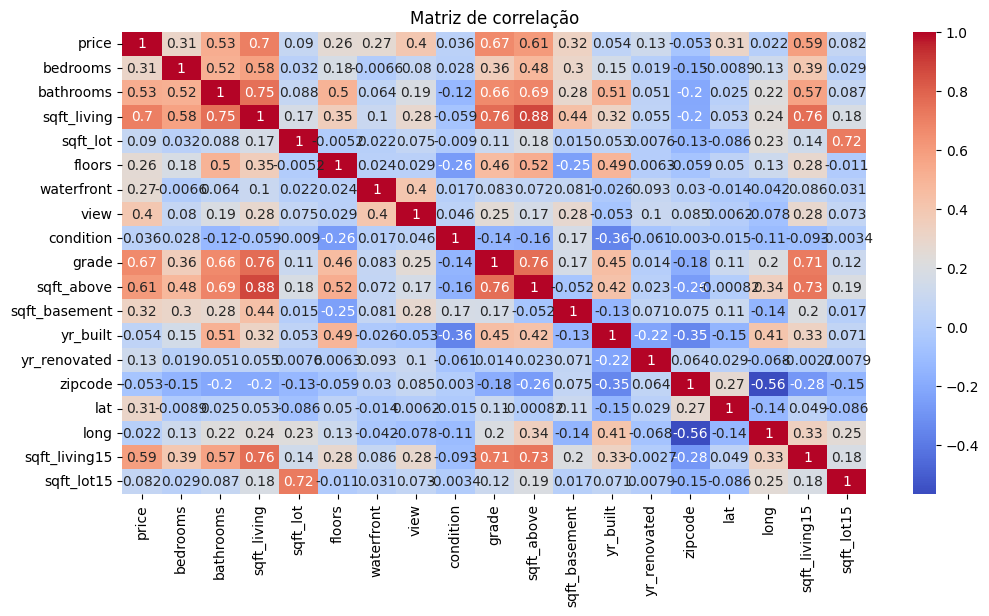

In [9]:
# Correlação entre as variaveis
df_correlacao = df_house_sales.drop(columns=['id', 'date'])

plt.figure(figsize=(12, 6))
correlation_matrix = df_correlacao.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlação')
plt.show()

Analise sobre a correlação:
<p>Podemos ver que a variavel price(preço) tem muita relação com as variaveis de bathrooms(quantiade de quantos), sqft_living(metragem interna do apartamento), e o grade(indice do design da construção).</p>
<p>E podemos ver uma correlação negativa de ZipCode e price(preço), acredito que seja porque quanto menor o zipcode mais proximo ao centro e seja uma area valorizada. Isso é apenas um palpite que não sera levado em conta</p>

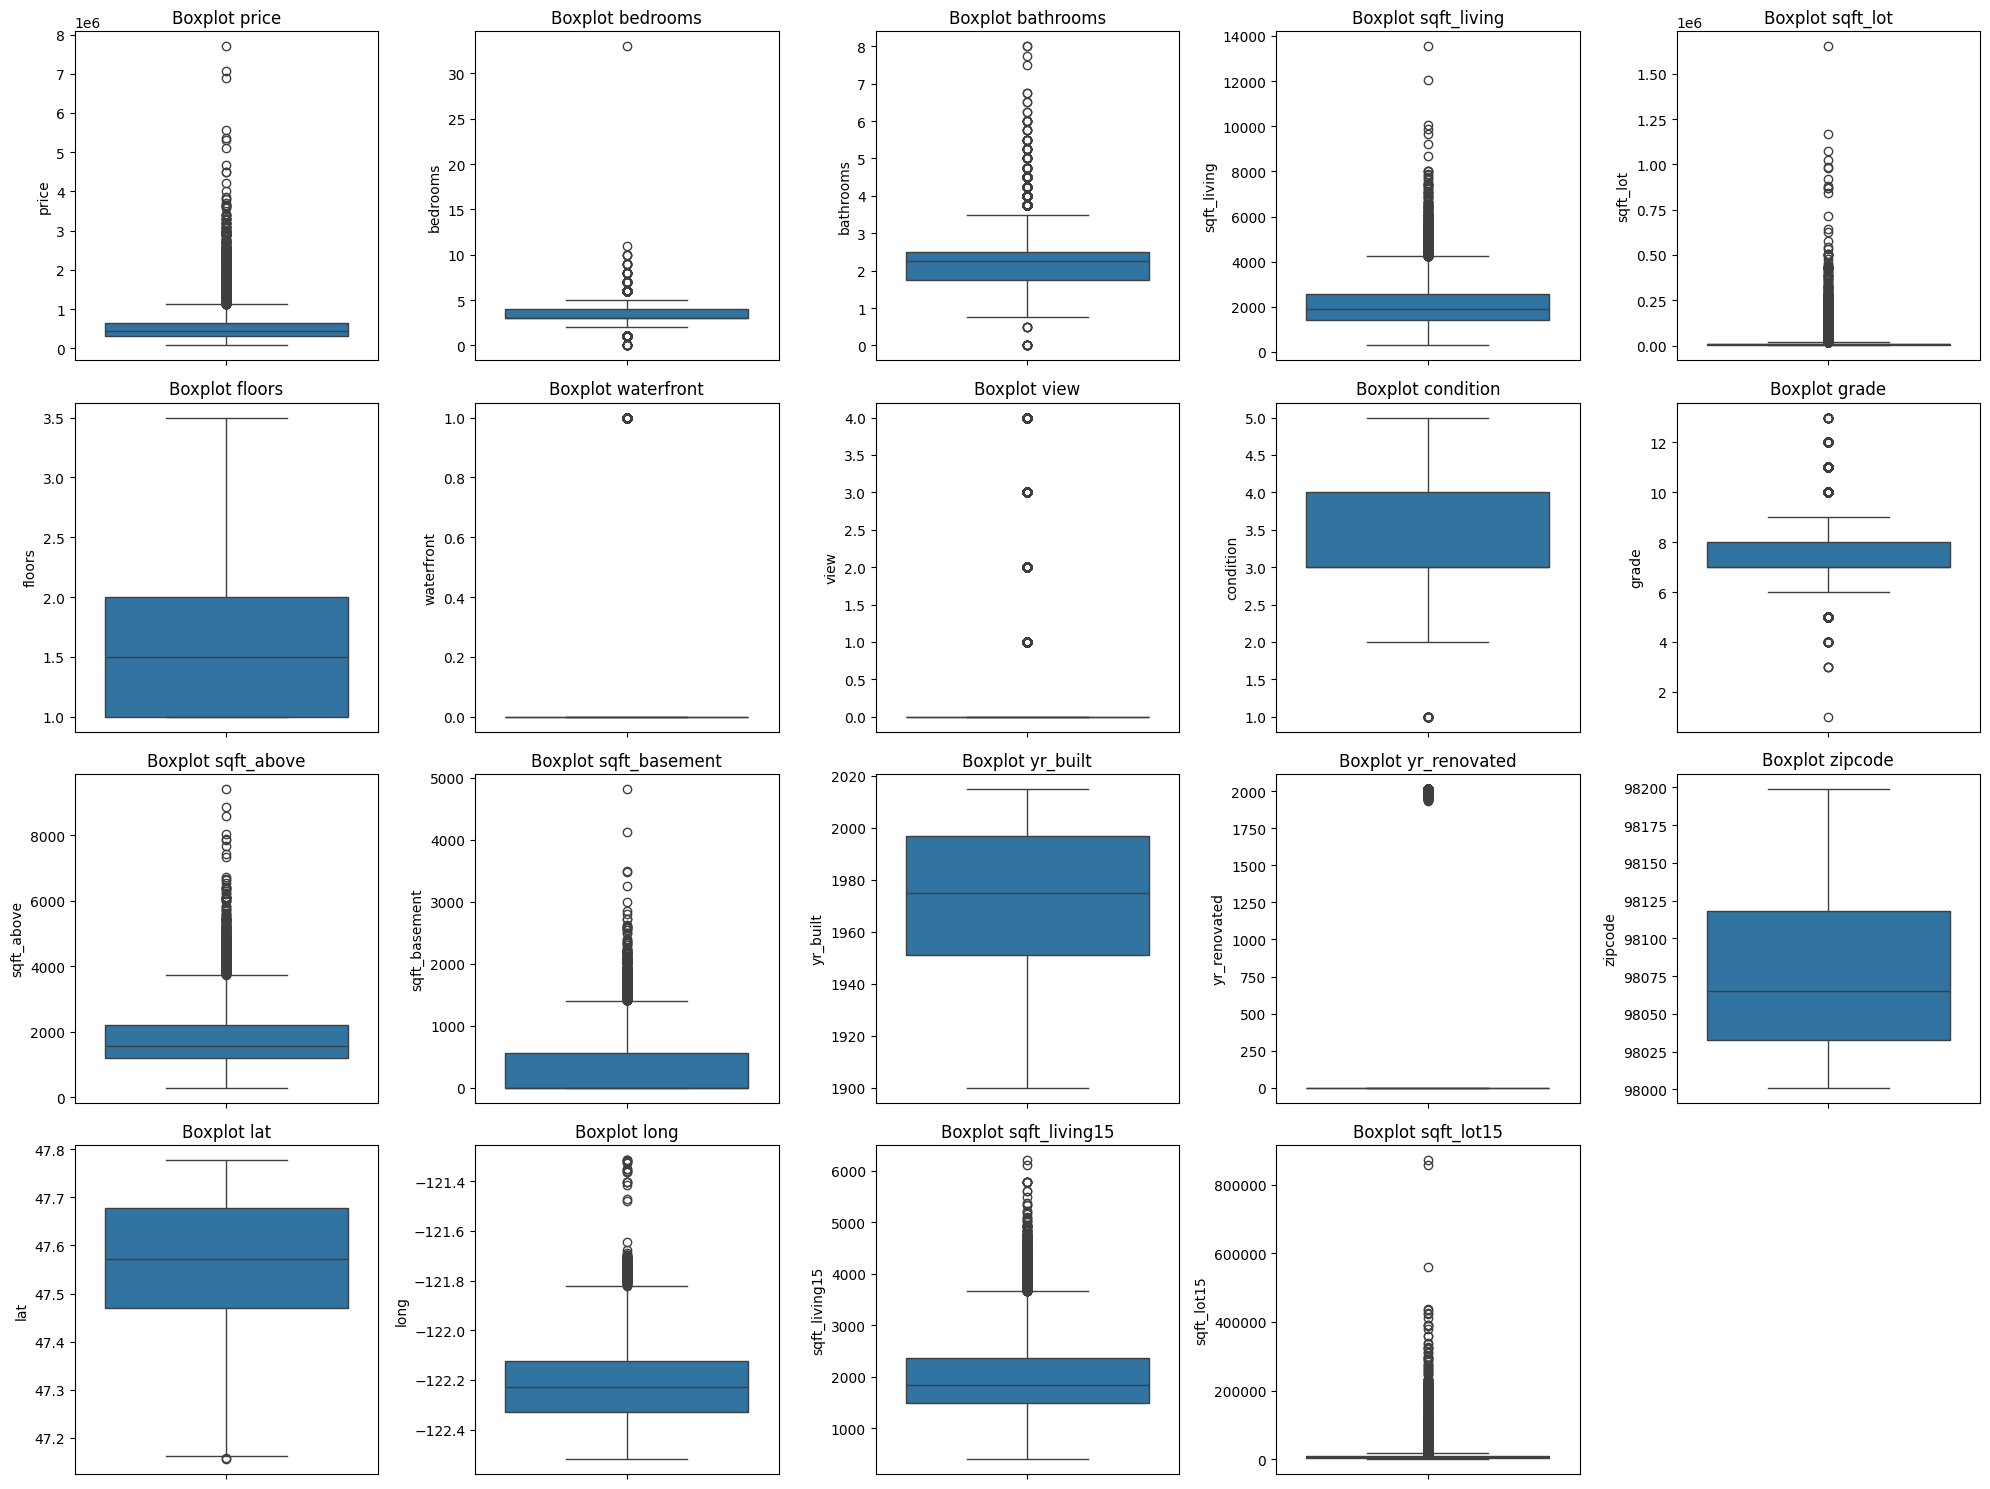

In [10]:
# BoxPlot
plt.figure(figsize=(20, 15))
df_house_sales_boxplot = df_house_sales.drop(columns=['id', 'date'])

for i, column in enumerate(df_house_sales_boxplot.columns, 1):
  plt.subplot(4, 5, i)
  sns.boxplot(y= df_house_sales_boxplot[column])
  plt.title(f'Boxplot {column}')
  plt.tight_layout()

plt.show()

In [11]:
import matplotlib.dates as mdates


In [12]:
# Estudo do preço em relação ao tempo
preco_medio = df_house_sales.groupby('date')['price'].mean().reset_index()

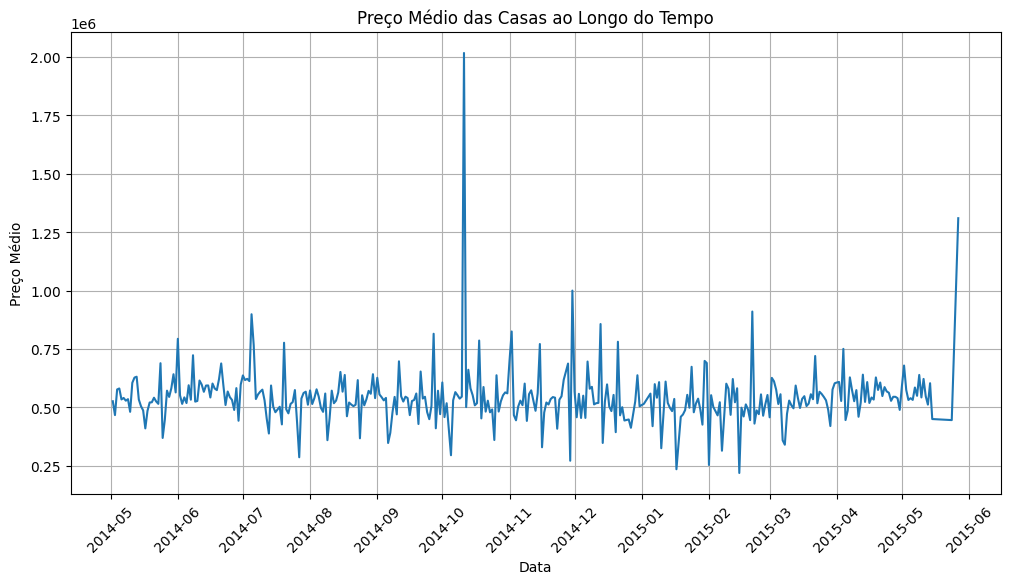

In [13]:
# Grafico de linhas
plt.figure(figsize=(12, 6))
sns.lineplot(data=preco_medio, x='date', y='price')


plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Data')
plt.ylabel('Preço Médio')
plt.title('Preço Médio das Casas ao Longo do Tempo')

plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [14]:
df_house_com_ano_mes = df_house_sales.copy()
df_house_com_ano_mes['ano'] = df_house_com_ano_mes['date'].dt.year
df_house_com_ano_mes['mes'] = df_house_com_ano_mes['date'].dt.month

In [15]:
# Vendo se as vendas são altas ou existe algum outlier em algum mes
sales_per_year_month = df_house_com_ano_mes.groupby(['ano', 'mes'])['id'].count().reset_index()

# Renomear as colunas para facilitar a leitura
sales_per_year_month.columns = ['Ano', 'Mês', 'Quantidade de Vendas']

# Exibir o resultado
print(sales_per_year_month)


     Ano  Mês  Quantidade de Vendas
0   2014    5                  1768
1   2014    6                  2180
2   2014    7                  2211
3   2014    8                  1940
4   2014    9                  1774
5   2014   10                  1878
6   2014   11                  1411
7   2014   12                  1471
8   2015    1                   978
9   2015    2                  1250
10  2015    3                  1875
11  2015    4                  2231
12  2015    5                   646


Em 2014-10 há um salto muito evidente, possivelmente é um outlier. Talvez para realizar uma analise mais aprofundada sobre os preços dos apartamentos por mes vale a pena tira-lo, mas como não é o meu foco neste estudo vou mante-lo pois seu preço é importante para a caracterizar do imovel.

In [16]:
# Quero saber quais são os ZipCodes que tem os maiores preços
preco_medio_zipcode = df_house_com_ano_mes.groupby('zipcode')['price'].mean().reset_index()

preco_medio_zipcode = preco_medio_zipcode.sort_values(by='price', ascending=False)

top_10_zipcodes = preco_medio_zipcode.head(10)

print(top_10_zipcodes)

    zipcode         price
24    98039  2.160607e+06
3     98004  1.355927e+06
25    98040  1.194230e+06
48    98112  1.095499e+06
41    98102  9.012583e+05
47    98109  8.796236e+05
43    98105  8.628252e+05
5     98006  8.596848e+05
53    98119  8.494480e+05
4     98005  8.101649e+05


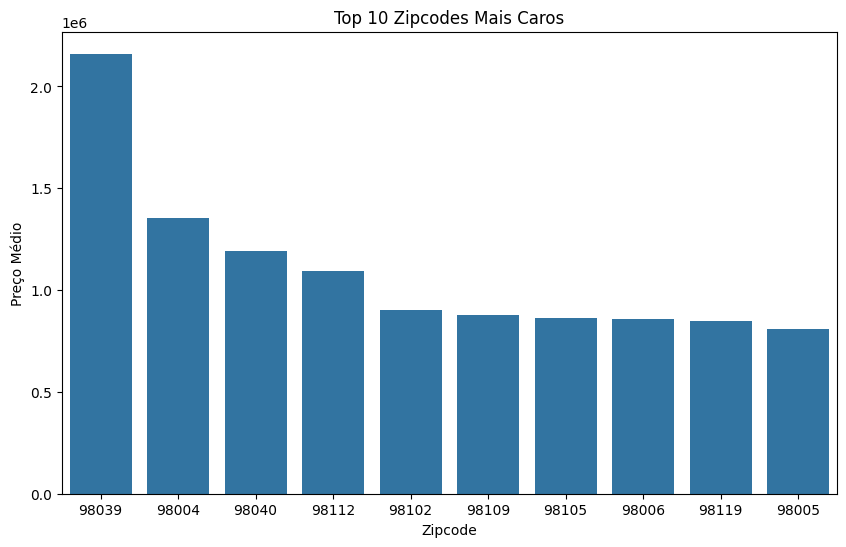

In [17]:
# Plotar os 10 zipcodes mais caros
top_10_zipcodes = top_10_zipcodes.sort_values(by='price', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='zipcode', y='price', data=top_10_zipcodes, order=top_10_zipcodes['zipcode'] )
plt.title('Top 10 Zipcodes Mais Caros')
plt.xlabel('Zipcode')
plt.ylabel('Preço Médio')
plt.show()

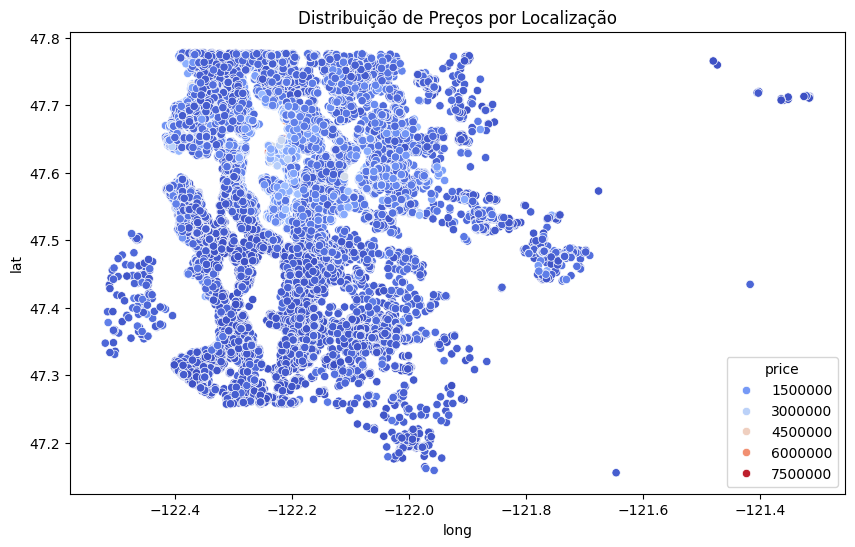

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='long', y='lat', hue='price', data=df_house_sales, palette='coolwarm')
plt.title('Distribuição de Preços por Localização')
plt.show()

Com esse grafico podemos ver os locais dos imoveis e vemos que os valores mais altos estão no centro do mapa, o que pode indicar o centro da cidade.

Analise de Preço com Waterfront

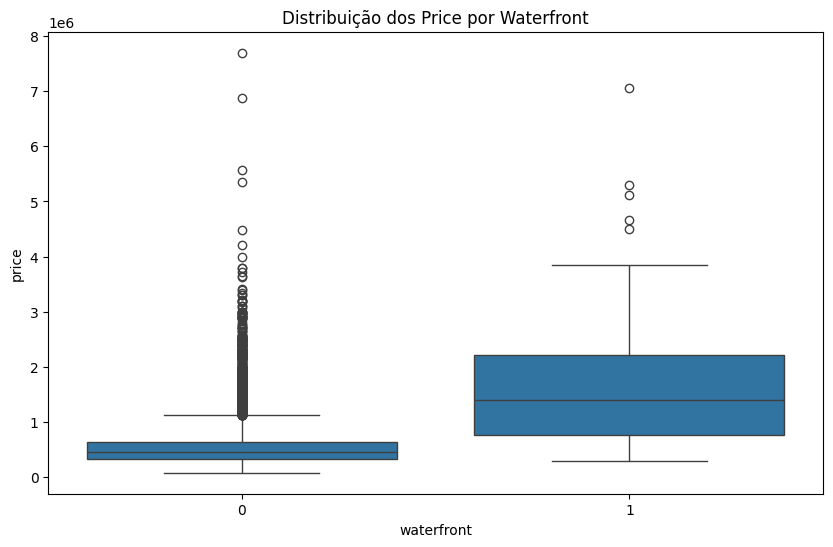

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='waterfront', y='price', data=df_house_sales)
plt.title('Distribuição dos Price por Waterfront')
plt.show()

Podemos ver que o waterfront influencia o preço dos imoveis.

Analise de Price com Grade

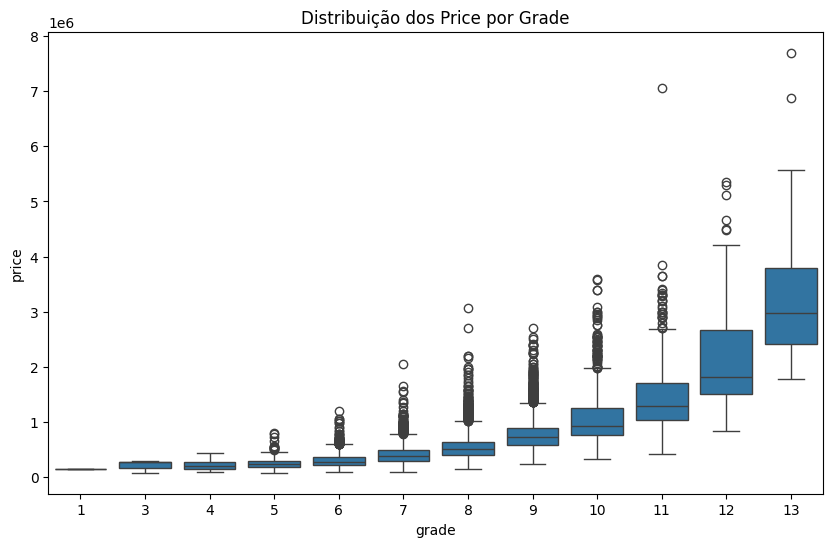

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='price', data=df_house_sales)
plt.title('Distribuição dos Price por Grade')
plt.show()

Como dito antes lá no grafico de correlação, vemos como a variavel Grade tem muita correlação com a variavel Price, aqui vemos a subi dos preços em quanto o grade, que é o nivel crescente de design de um imovel, também sobe.

Analise de Price com Condition

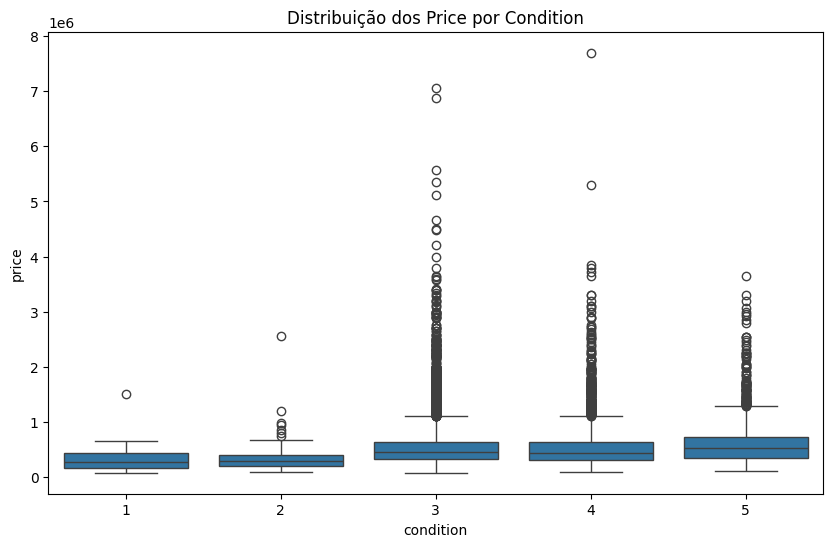

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='price', data=df_house_sales)
plt.title('Distribuição dos Price por Condition')
plt.show()

Aqui podemos ver que existe uma mudança nos preços nos quais quanto melhor a condição do imoveis maiores valor podemos ter. E podemos ver que existe muitos outliers.

# Retirando o id para iniciar o treinamento dos modelos

In [22]:
df_house_sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [27]:
# Tirando coluna de ID e precisamos quebrar o date
df_final = df_house_sales.drop(columns=['id'])

df_final['ano'] = df_house_sales['date'].dt.year
df_final['mes'] = df_house_sales['date'].dt.month
df_final = df_final.drop(columns=['date'])

df_final.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,ano,mes
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2


# Modelos de predição

Vou treinar os modelos para ver qual se sai melhor. Utilizarei Regressão linear, Random Forest e Gradient Boosting.

In [28]:
X = df_final.drop('price', axis=1)
y = df_final['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
# Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

In [30]:
# Random Forest
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

In [31]:
# Grandient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

In [35]:
# XGBoosting
xgboost_model = xgb.XGBRegressor(random_state=42)
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)

In [32]:
# Criando uma função para avaliamos os modelos
def avaliar_modelo(y_test, y_pred, modelo_nome):
    print(f'\n{modelo_nome}')
    print(f'R²: {r2_score(y_test, y_pred)}')
    print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
    print(f'RMSE: {mean_squared_error(y_test, y_pred, squared=False)}')

In [36]:
avaliar_modelo(y_test, y_pred_linear, 'Regressão Linear')
avaliar_modelo(y_test, y_pred_rf, 'Random Forest')
avaliar_modelo(y_test, y_pred_gb, 'Gradient Boosting')
avaliar_modelo(y_test, y_pred_xgb, 'XGBoost')


Regressão Linear
R²: 0.7008351137635616
MAE: 127003.00883453706
RMSE: 207820.58849230103

Random Forest
R²: 0.8535395338142061
MAE: 73462.62785934607
RMSE: 145409.72979545072

Gradient Boosting
R²: 0.8572458966946859
MAE: 81104.69862762206
RMSE: 143558.05364135694

XGBoost
R²: 0.867722507806524
MAE: 70545.40816577345
RMSE: 138189.87935517507


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

<p>Então vemos que o melhor modelo é o XGBoost, seguido de Gradient e Random Forest, e depois a Regressão Linear.</p>

<p>O Gradient Boosting e o Random Forest tiveram valores muito proximos um do outro, mas o Erro Medio Absoluto(MAE) o do Random Forest é 7642 de diferença o que indica que o Random Forest comete erros menores com valores absolutos. Mas o RMSE volta a ser proximo então sugere que ambos têm um desempenho semelhante em lidar com erros maiores (outliers). </p>

<p>A Regressão ficou bem ruim, seu R² de 70% o que indica que não conseguiu captar bem a variação das variaveis. O MAE e RMSE são muito altos o que indica que traçar uma linha nesse conjunto de dados não é a melhor solução.</p>

<p>E por ultimo temos o XGBoost, que apresentou os melhores resultados em todas as métricas, o melhor R², o menor MAE e o também o menor RMSE. Este modelo soube se adquar melhor ao conjunto de dados, o que era esperado já que o XGBoost é um modelo melhorado do Gradient Boosting.</p>
